In [2]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [3]:
def read_file(file_name):
    return pd.read_csv(file_name, sep=';')

def get_memory_stat_by_column(df):
    memory_usage_stat = df.memory_usage(deep=True)
    total_memory_usage = memory_usage_stat.sum()
    print(f"file in memory size = {total_memory_usage // 1024:10} КБ")
    column_stat = list()
    for key in df.dtypes.keys():
        column_stat.append({
            "column_name": key,
            "memory_abs": float(memory_usage_stat[key] // 1024),
            "memory_per": round(memory_usage_stat[key] / total_memory_usage * 100, 4),
            "dtype": str(df.dtypes[key])
        })
    column_stat.sort(key=lambda x: x['memory_abs'], reverse=True)
    for column in column_stat:
        print(
            f"{column['column_name']:15}: {int(column['memory_abs']):10} КБ: {column['memory_per']:10}% : {column['dtype']}")
    return column_stat


def mem_usage(pandas_obj):
    if isinstance(pandas_obj, pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else:  # предположим, что если это не датафрейм, то серия
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2  # преобразуем байты в мегабайты
    return "{:03.2f} MB".format(usage_mb)

In [4]:
def opt_obj(df):
    converted_obj = pd.DataFrame()
    dataset_obj = df.select_dtypes(include=['object']).copy()

    for col in dataset_obj.columns:
        num_unique_values = len(dataset_obj[col].unique())
        num_total_values = len(dataset_obj[col])
        if num_unique_values / num_total_values < 0.5:
            converted_obj.loc[:, col] = dataset_obj[col].astype('category')
        else:
            converted_obj.loc[:, col] = dataset_obj[col]

    print(mem_usage(dataset_obj))
    print(mem_usage(converted_obj))
    return converted_obj

def opt_int(df):
    dataset_int = df.select_dtypes(include=['int'])
    """
    downcast:
            - 'integer' or 'signed': smallest signed int dtype (min.: np.int8)
            - 'unsigned': smallest unsigned int dtype (min.: np.uint8)
            - 'float': smallest float dtype (min.: np.float32)
    """
    converted_int = dataset_int.apply(pd.to_numeric, downcast='unsigned')
    print(mem_usage(dataset_int))
    print(mem_usage(converted_int))
    #
    compare_ints = pd.concat([dataset_int.dtypes, converted_int.dtypes], axis=1)
    compare_ints.columns = ['before', 'after']
    compare_ints.apply(pd.Series.value_counts)
    print(compare_ints)

    return converted_int


def opt_float(df):
    # # =======================================================================
    # # выполняем понижающее преобразование
    # # для столбцов типа float
    dataset_float = df.select_dtypes(include=['float'])
    converted_float = dataset_float.apply(pd.to_numeric, downcast='float')

    print(mem_usage(dataset_float))
    print(mem_usage(converted_float))

    compare_floats = pd.concat([dataset_float.dtypes, converted_float.dtypes], axis=1)
    compare_floats.columns = ['before', 'after']
    compare_floats.apply(pd.Series.value_counts)
    print(compare_floats)

    return converted_float

In [5]:
file_name = "/content/drive/My Drive/DI_LR6/Russia_Real_Estate_2021.csv"
dataset = read_file(file_name)

In [6]:
non_optimized_stat = get_memory_stat_by_column(dataset)

with open('non_optimized_stat.json', 'w', encoding='utf-8') as f:
    json.dump(non_optimized_stat, f, ensure_ascii=False, indent=4)

file in memory size =    1985457 КБ
date           :     743160 КБ:    37.4302% : object
price          :      88735 КБ:     4.4693% : int64
level          :      88735 КБ:     4.4693% : int64
levels         :      88735 КБ:     4.4693% : int64
rooms          :      88735 КБ:     4.4693% : int64
area           :      88735 КБ:     4.4693% : float64
kitchen_area   :      88735 КБ:     4.4693% : float64
geo_lat        :      88735 КБ:     4.4693% : float64
geo_lon        :      88735 КБ:     4.4693% : float64
building_type  :      88735 КБ:     4.4693% : int64
object_type    :      88735 КБ:     4.4693% : int64
postal_code    :      88735 КБ:     4.4693% : float64
street_id      :      88735 КБ:     4.4693% : float64
id_region      :      88735 КБ:     4.4693% : int64
house_id       :      88735 КБ:     4.4693% : float64


In [7]:
optimized_dataset = dataset.copy()

converted_obj = opt_obj(dataset)
converted_int = opt_int(dataset)
converted_float = opt_float(dataset)

725.74 MB
21.70 MB
606.59 MB
227.47 MB
              before   after
price          int64  uint64
level          int64   uint8
levels         int64   uint8
rooms          int64   int64
building_type  int64   uint8
object_type    int64   uint8
id_region      int64   uint8
606.59 MB
303.30 MB
               before    after
area          float64  float32
kitchen_area  float64  float32
geo_lat       float64  float32
geo_lon       float64  float32
postal_code   float64  float32
street_id     float64  float32
house_id      float64  float32


In [8]:
optimized_dataset[converted_obj.columns] = converted_obj
optimized_dataset[converted_int.columns] = converted_int
optimized_dataset[converted_float.columns] = converted_float

print(mem_usage(dataset))
print(mem_usage(optimized_dataset))
optimized_dataset.info(memory_usage='deep')

1938.92 MB
552.46 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11358150 entries, 0 to 11358149
Data columns (total 15 columns):
 #   Column         Dtype   
---  ------         -----   
 0   date           category
 1   price          uint64  
 2   level          uint8   
 3   levels         uint8   
 4   rooms          int64   
 5   area           float32 
 6   kitchen_area   float32 
 7   geo_lat        float32 
 8   geo_lon        float32 
 9   building_type  uint8   
 10  object_type    uint8   
 11  postal_code    float32 
 12  street_id      float32 
 13  id_region      uint8   
 14  house_id       float32 
dtypes: category(1), float32(7), int64(1), uint64(1), uint8(5)
memory usage: 552.5 MB


In [9]:
optimized_stat = get_memory_stat_by_column(optimized_dataset)

with open('optimized_stat.json', 'w', encoding='utf-8') as f:
    json.dump(optimized_stat, f, ensure_ascii=False, indent=4)

file in memory size =     565721 КБ
price          :      88735 КБ:    15.6854% : uint64
rooms          :      88735 КБ:    15.6854% : int64
area           :      44367 КБ:     7.8427% : float32
kitchen_area   :      44367 КБ:     7.8427% : float32
geo_lat        :      44367 КБ:     7.8427% : float32
geo_lon        :      44367 КБ:     7.8427% : float32
postal_code    :      44367 КБ:     7.8427% : float32
street_id      :      44367 КБ:     7.8427% : float32
house_id       :      44367 КБ:     7.8427% : float32
date           :      22215 КБ:      3.927% : category
level          :      11091 КБ:     1.9607% : uint8
levels         :      11091 КБ:     1.9607% : uint8
building_type  :      11091 КБ:     1.9607% : uint8
object_type    :      11091 КБ:     1.9607% : uint8
id_region      :      11091 КБ:     1.9607% : uint8


In [10]:
need_column = dict()
column_names = ['date', 'price', 'level',
                 'levels', 'rooms', 'area',
                 'geo_lat', 'geo_lon', 'id_region', 'building_type']

opt_dtypes = optimized_dataset.dtypes
for key in dataset.columns:
    need_column[key] = opt_dtypes[key]
    print(f"{key}:{opt_dtypes[key]}")

with open("dtypes.json", mode="w") as file:
    dtype_json = need_column.copy()
    for key in dtype_json.keys():
        dtype_json[key] = str(dtype_json[key])

    json.dump(dtype_json, file)

date:category
price:uint64
level:uint8
levels:uint8
rooms:int64
area:float32
kitchen_area:float32
geo_lat:float32
geo_lon:float32
building_type:uint8
object_type:uint8
postal_code:float32
street_id:float32
id_region:uint8
house_id:float32


In [11]:
read_and_optimized = pd.read_csv(file_name, usecols=lambda x: x in column_names, dtype=need_column, sep=';')
print(read_and_optimized)

get_memory_stat_by_column(read_and_optimized)

                date     price  level  levels  rooms       area    geo_lat  \
0         2021-01-01   2451300     15      31      1  30.299999  56.780113   
1         2021-01-01   1450000      5       5      1  33.000000  44.608154   
2         2021-01-01  10700000      4      13      3  85.000000  55.540062   
3         2021-01-01   3100000      3       5      3  82.000000  44.608154   
4         2021-01-01   2500000      2       3      1  30.000000  44.738686   
...              ...       ...    ...     ...    ...        ...        ...   
11358145  2021-12-31   6099000      4       9      3  65.000000  56.041538   
11358146  2021-12-31   2490000      1      10      2  56.900002  55.169949   
11358147  2021-12-31    850000      2       2      2  37.000000  55.946205   
11358148  2021-12-31   4360000      5       5      1  36.000000  61.256382   
11358149  2021-12-31   1850000      1       5      1  33.000000  55.164520   

            geo_lon  building_type  id_region  
0         60.69

[{'column_name': 'price',
  'memory_abs': 88735.0,
  'memory_per': 23.5274,
  'dtype': 'uint64'},
 {'column_name': 'rooms',
  'memory_abs': 88735.0,
  'memory_per': 23.5274,
  'dtype': 'int64'},
 {'column_name': 'area',
  'memory_abs': 44367.0,
  'memory_per': 11.7637,
  'dtype': 'float32'},
 {'column_name': 'geo_lat',
  'memory_abs': 44367.0,
  'memory_per': 11.7637,
  'dtype': 'float32'},
 {'column_name': 'geo_lon',
  'memory_abs': 44367.0,
  'memory_per': 11.7637,
  'dtype': 'float32'},
 {'column_name': 'date',
  'memory_abs': 22215.0,
  'memory_per': 5.8903,
  'dtype': 'category'},
 {'column_name': 'level',
  'memory_abs': 11091.0,
  'memory_per': 2.9409,
  'dtype': 'uint8'},
 {'column_name': 'levels',
  'memory_abs': 11091.0,
  'memory_per': 2.9409,
  'dtype': 'uint8'},
 {'column_name': 'building_type',
  'memory_abs': 11091.0,
  'memory_per': 2.9409,
  'dtype': 'uint8'},
 {'column_name': 'id_region',
  'memory_abs': 11091.0,
  'memory_per': 2.9409,
  'dtype': 'uint8'}]

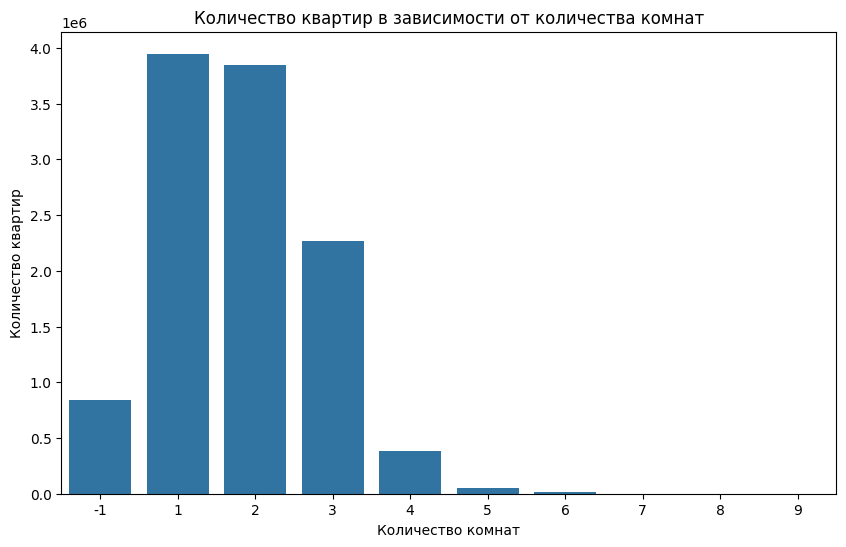

In [14]:
def figure1(read_and_optimized):
  plt.figure(figsize=(10, 6))
  sns.countplot(x='rooms', data=read_and_optimized)
  plt.title('Количество квартир в зависимости от количества комнат')
  plt.xlabel('Количество комнат')
  plt.ylabel('Количество квартир')
  plt.show()

figure1(read_and_optimized)

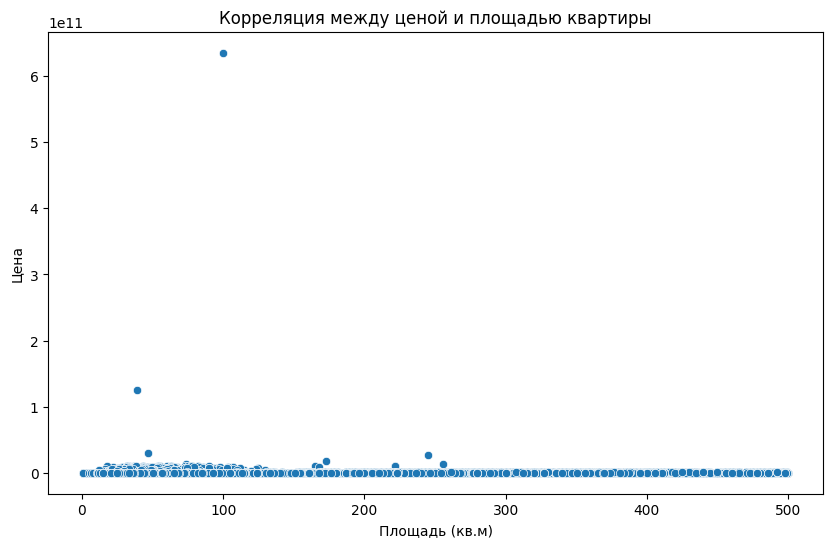

In [15]:
def figure2(read_and_optimized):
  plt.figure(figsize=(10, 6))
  sns.scatterplot(x='area', y='price', data=read_and_optimized)
  plt.title('Корреляция между ценой и площадью квартиры')
  plt.xlabel('Площадь (кв.м)')
  plt.ylabel('Цена')
  plt.show()

figure2(read_and_optimized)

<ipython-input-21-7ee5e12fbdd9>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='levels', y='price', data=read_and_optimized, showfliers=False, palette='coolwarm')


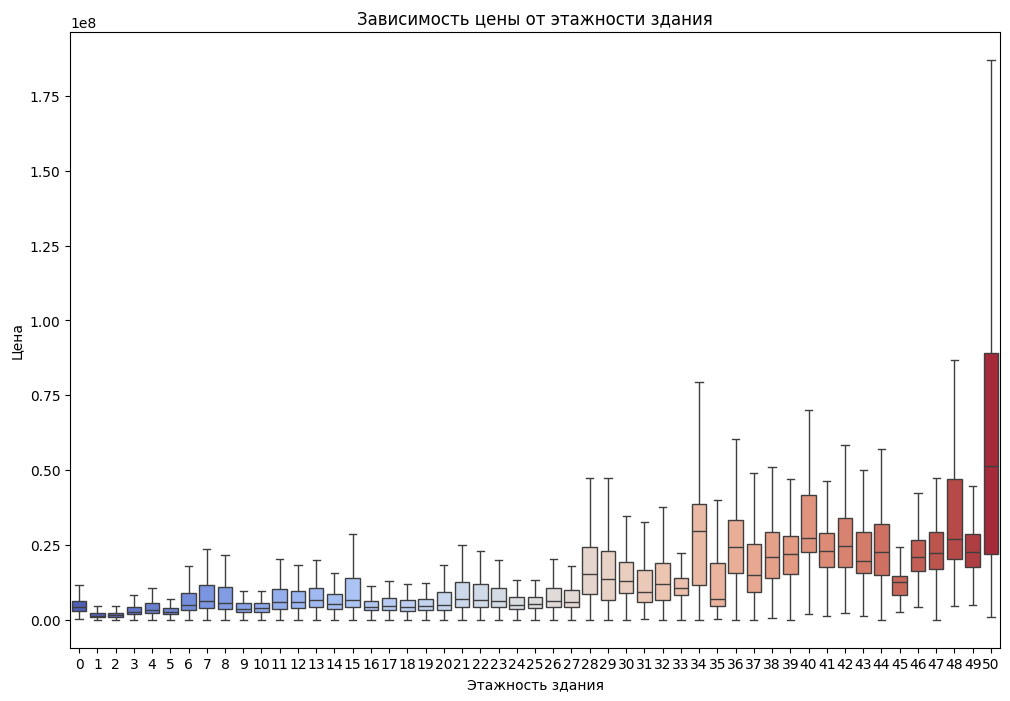

In [21]:
def figure3(read_and_optimized):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x='levels', y='price', data=read_and_optimized, showfliers=False, palette='coolwarm')
    plt.title('Зависимость цены от этажности здания')
    plt.xlabel('Этажность здания')
    plt.ylabel('Цена')
    plt.show()

figure3(read_and_optimized)


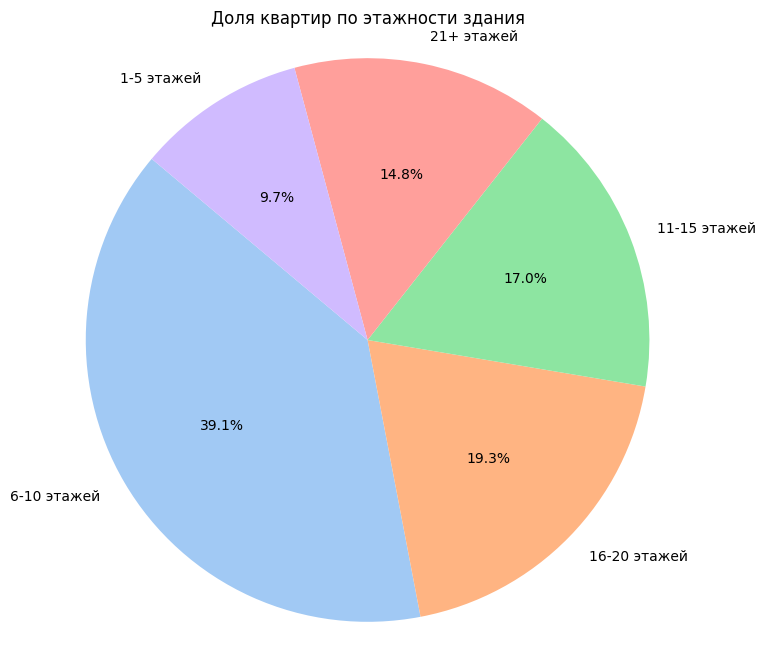

In [25]:
def figure4(read_and_optimized):
    bins = [0, 5, 10, 15, 20, 50]
    labels = ['1-5 этажей', '6-10 этажей', '11-15 этажей', '16-20 этажей', '21+ этажей']

    read_and_optimized['levels_grouped'] = pd.cut(read_and_optimized['levels'], bins=bins, labels=labels, right=False)

    levels_counts = read_and_optimized['levels_grouped'].value_counts()

    plt.figure(figsize=(8, 8))
    plt.pie(levels_counts, labels=levels_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
    plt.title('Доля квартир по этажности здания')
    plt.axis('equal')
    plt.show()

figure4(read_and_optimized)

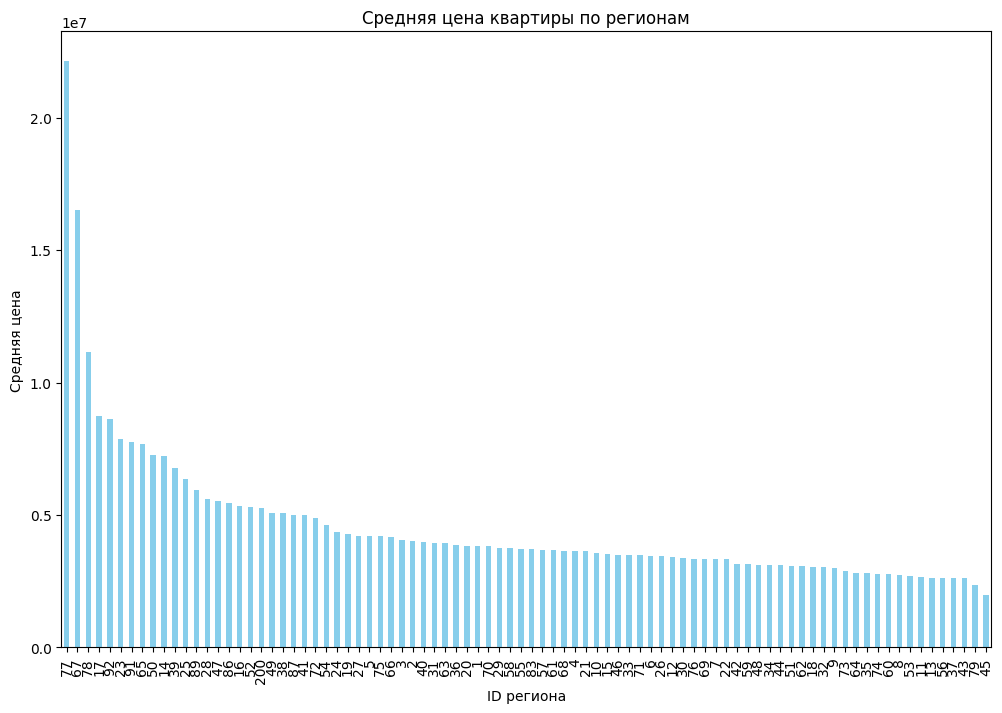

In [28]:
def figure5(read_and_optimized):
    avg_price_by_region = read_and_optimized.groupby('id_region')['price'].mean().sort_values(ascending=False)
    plt.figure(figsize=(12, 8))
    avg_price_by_region.plot(kind='bar', color='skyblue')
    plt.title('Средняя цена квартиры по регионам')
    plt.xlabel('ID региона')
    plt.ylabel('Средняя цена')
    plt.show()

figure5(read_and_optimized)

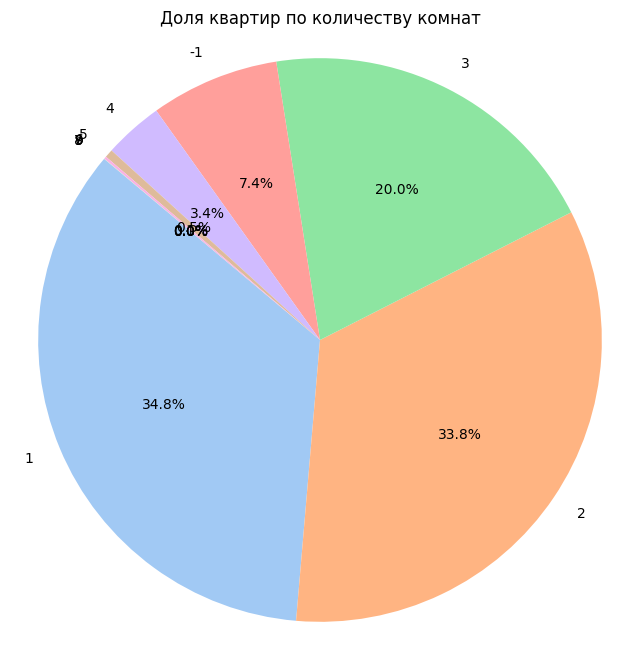

In [32]:
def figure6(read_and_optimized):
    rooms_counts = read_and_optimized['rooms'].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(
        rooms_counts,
        labels=rooms_counts.index,
        autopct='%1.1f%%',
        startangle=140,
        colors=sns.color_palette('pastel')
    )
    plt.title('Доля квартир по количеству комнат')
    plt.axis('equal')
    plt.show()

figure6(read_and_optimized)